---
format:
  html:
    code-fold: false
---

## Dynamic fracture

In [1]:
import jax

jax.config.update("jax_enable_x64", True)  # use double-precision
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)
jax.config.update("jax_platforms", "cpu")
import jax.numpy as jnp
from jax import Array

import femsolver
from femsolver.utils import auto_vmap
from femsolver import Mesh, Operator, element
from femsolver.plotting import STYLE_PATH, colors
from petsc4py import PETSc


from typing import Callable, Optional, Tuple

import matplotlib.pyplot as plt
import cmcrameri.cm as cmc


### Griffith's critical length

The critical length for plain strain condition is given by:

$$L_\text{G} = 2\mu \Gamma/\pi(1-\nu)\sigma_{\infty}^2$$

where $\mu$ is the shear modulus, $\Gamma$ is the fracture energy, $\nu$ is the Poisson's ratio, and $\sigma_{\infty}$ is the stress at infinity.

For plain strain condition, the effective Young's modulus is given by:

$$E_\text{eff} = \frac{E}{1-\nu^2}$$

where $E$ is the Young's modulus and $\nu$ is the Poisson's ratio.


For a specimen stretched by a prestrain $\epsilon$, the applied stress at infinity is given by:

$$\sigma_{\infty} = \epsilon /E_\text{eff}$$

In [49]:
prestrain = 0.01
nu = 0.35

E = 106e3 # N/m^2
lmbda = nu * E / ((1 + nu) * (1 - 2 * nu))
mu = E / (2 * (1 + nu))

Gamma = 15 # J/m^2
sigma_c = 20e3 # N/m^2

print(f"mu: {mu} N/m^2")
print(f"lmbda: {lmbda} N/m^2")

sigma_inf = prestrain * E

L_G = 2 * mu * Gamma / (jnp.pi * (1 - nu) * sigma_inf**2)
print(f"L_G: {L_G} m")


mu: 39259.259259259255 N/m^2
lmbda: 91604.93827160491 N/m^2
L_G: 0.5133202486434296 m


In [50]:
def generate_mesh_with_line_elements(
    nx: int,
    ny: int,
    lxs: Tuple[float, float],
    lys: Tuple[float, float],
    curve_func: Optional[Callable[[jnp.ndarray, float], bool]] = None,
    tol: float = 1e-6,
) -> Tuple[jnp.ndarray, jnp.ndarray, Optional[jnp.ndarray]]:
    """
    Generates a 2D triangular mesh for a rectangle and optionally extracts
    1D line elements along a specified curve.

    Args:
        nx: Number of elements along the x-direction.
        ny: Number of elements along the y-direction.
        lxs: Tuple of the x-coordinates of the left and right edges of the rectangle.
        lys: Tuple of the y-coordinates of the bottom and top edges of the rectangle.
        curve_func: An optional callable that takes a coordinate array [x, y] and
                    a tolerance, returning True if the point is on the curve.
        tol: Tolerance for floating-point comparisons.

    Returns:
        A tuple containing:
        - coords (jnp.ndarray): Nodal coordinates, shape (num_nodes, 2).
        - elements_2d (jnp.ndarray): 2D triangular element connectivity.
        - elements_1d (jnp.ndarray | None): 1D line element connectivity, or None.
    """

    x = jnp.linspace(lxs[0], lxs[1], nx + 1)
    y = jnp.linspace(lys[0], lys[1], ny + 1)
    xv, yv = jnp.meshgrid(x, y, indexing="ij")
    coords = jnp.stack([xv.ravel(), yv.ravel()], axis=-1)

    def node_id(i, j):
        return i * (ny + 1) + j

    elements_2d = []
    for i in range(nx):
        for j in range(ny):
            n0 = node_id(i, j)
            n1 = node_id(i + 1, j)
            n2 = node_id(i, j + 1)
            n3 = node_id(i + 1, j + 1)
            elements_2d.append([n0, n1, n3])
            elements_2d.append([n0, n3, n2])
    elements_2d = jnp.array(elements_2d)

    # --- 2. Extract 1D elements if a curve function is provided ---
    if curve_func is None:
        return coords, elements_2d, None

    # Efficiently find all nodes on the curve using jax.vmap
    on_curve_mask = jax.vmap(lambda c: curve_func(c, tol))(coords)

    elements_1d = []
    # Iterate through all 2D elements to find edges on the curve
    for tri in elements_2d:
        # Define the three edges of the triangle
        edges = [(tri[0], tri[1]), (tri[1], tri[2]), (tri[2], tri[0])]
        for n_a, n_b in edges:
            # If both nodes of an edge are on the curve, add it to the set
            if on_curve_mask[n_a] and on_curve_mask[n_b]:
                # Sort to store canonical representation, e.g., (1, 2) not (2, 1)
                elements_1d.append(tuple(sorted((n_a, n_b))))

    if not elements_1d:
        return coords, elements_2d, jnp.array([], dtype=int)

    return coords, elements_2d, jnp.unique(jnp.array(elements_1d), axis=0)

Generated 561 nodes.
Generated 1000 2D triangular elements.
Found 37 1D line elements on the curve.


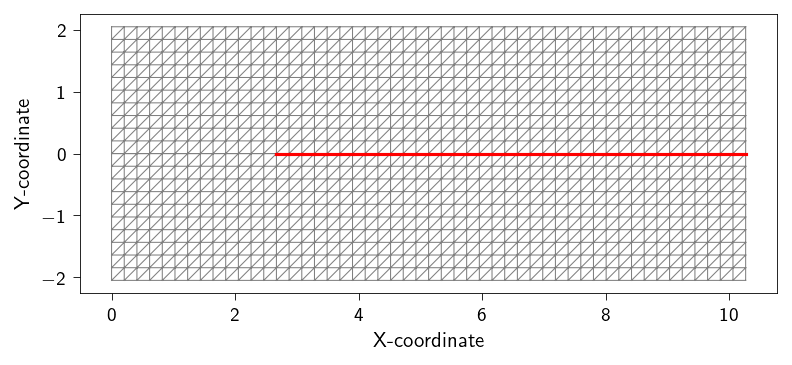

In [87]:
Nx = 50  # Number of elements in X
Ny = 10  # Number of elements in Y
Lx = 20*L_G  # Length in X
Ly = 4*L_G  # Length in Y


crack_length = 5*L_G

# function identifies nodes on the cohesive line at y = 0. and x > 2.0
def cohesive_line(coord: jnp.ndarray, tol: float) -> bool:
    return jnp.logical_and(jnp.isclose(coord[1], 0.0, atol=tol), coord[0] > crack_length)


upper_coords, upper_elements_2d, upper_elements_1d = generate_mesh_with_line_elements(
    nx=Nx, ny=Ny, lxs=(0, Lx), lys=(0, Ly), curve_func=cohesive_line
)


lower_coords, lower_elements_2d, lower_elements_1d = generate_mesh_with_line_elements(
    nx=Nx, ny=Ny, lxs=(0, Lx), lys=(-Ly, -1e-6), curve_func=cohesive_line
)

coords = jnp.vstack((upper_coords, lower_coords))
elements = jnp.vstack((upper_elements_2d, lower_elements_2d + upper_coords.shape[0]))
lower_elements_1d = lower_elements_1d + upper_coords.shape[0]

print(f"Generated {upper_coords.shape[0]} nodes.")
print(f"Generated {upper_elements_2d.shape[0]} 2D triangular elements.")
print(f"Found {upper_elements_1d.shape[0]} 1D line elements on the curve.")

plt.style.use(STYLE_PATH)
plt.figure(figsize=(6, 3))
ax = plt.axes()
ax.triplot(coords[:, 0], coords[:, 1], elements, color="grey", lw=0.5)


# Highlight the extracted 1D elements in red
for edge in upper_elements_1d:
    ax.plot(upper_coords[edge, 0], upper_coords[edge, 1], "r-", lw=1.5)
for edge in lower_elements_1d:
    ax.plot(lower_coords[edge, 0], lower_coords[edge, 1], "r-", lw=1.5)

ax.set_xlabel("X-coordinate")
ax.set_ylabel("Y-coordinate")
ax.set_aspect("equal")
plt.show()

In [88]:
mesh = Mesh(coords, elements)

To check that the elements along the cohesive line are in same order on both surface, we compare the node values for the two. 

In [89]:
jnp.allclose(coords[upper_elements_1d], coords[lower_elements_1d], atol=1e-6)

Array(True, dtype=bool)

In [90]:
# --- Mesh ---
n_nodes = upper_coords.shape[0]
n_nodes += lower_coords.shape[0]
n_dofs_per_node = 2
n_dofs = n_dofs_per_node * n_nodes

We define a function to compute the linear elastic energy density based on the displacement gradients $\nabla u$.

$$
\Psi(x) =  \sigma(x) : \epsilon(x) 
$$

where $\sigma$ is the stress tensor and $\epsilon$ is the strain tensor.

$$
\sigma = \lambda \text{tr}(\epsilon) I + 2\mu \epsilon
$$

and 

$$
\epsilon = \frac{1}{2} (\nabla u + \nabla u^T)
$$


The elastic strain energy density is then given by:

$$
\Psi_{elastic}(u) = \int_{\Omega} \Psi(x) dV
$$



In [91]:
from typing import NamedTuple


class Material(NamedTuple):
    """Material properties for the elasticity operator."""

    mu: float  # Diffusion coefficient
    lmbda: float  # Diffusion coefficient


mat = Material(mu=mu, lmbda=lmbda)

In [92]:
# --- Material model (linear elasticity: plane strain) ---
@auto_vmap(grad_u=2)
def compute_strain(grad_u):
    return 0.5 * (grad_u + grad_u.T)

@auto_vmap(eps=2, mu=0, lmbda=0)
def compute_stress(eps, mu, lmbda):
    I = jnp.eye(2)
    return 2 * mu * eps + lmbda * jnp.trace(eps) * I

@auto_vmap(grad_u=2, mu=0, lmbda=0)
def strain_energy(grad_u, mu, lmbda):
    eps = compute_strain(grad_u)
    sigma = compute_stress(eps, mu, lmbda)
    return 0.5 * jnp.sum(sigma * eps)


In [93]:
tri = element.Tri3()
op = Operator(mesh, tri)

In [94]:
@op.integrate
def total_strain_energy(u: Array, u_grad: Array, *_) -> Array:
    """Compute the total energy of the system."""
    return strain_energy(u_grad, mat.mu, mat.lmbda)

In the above definition of the ``FemOperator`` class, we have used the ``quad_tri3`` and ``shape_fn_tri3`` functions to compute the quadrature points and shape functions for the triangular elements.

One can simply replace these two functions with any other quadrature and shape function. Just look at the ``quad_tri3`` and ``shape_fn_tri3`` functions in ``femsolver/quadrature.py`` to see how to define your own.

For more complex problems, one can define their own implementation of the `FemOperator` class. One just have to inherit from the `FemOperator` class and override the functions that are needed.


Now we prepare the mesh and the boundary conditions and solve the linear elasticity problem.

The total potential energy $\Psi$ is the sum of the elastic strain energy $\Psi_{elastic}$ and the cohesive energy $\Psi_{cohesive}$.

$$\Psi(u)=\Psi_{elastic}(u)+\Psi_{cohesive}(u)$$

The cohesive energy is defined as:

$$\Psi_{cohesive}(u)= \int_{\Gamma_\text{coh}} \psi(\delta(\boldsymbol{u})) dA$$

where 

- $\Gamma_{coh}$ is the cohesive interface.

- $\boldsymbol{\delta}(\boldsymbol{u}) = \boldsymbol{u}^+ - \boldsymbol{u}^-$ is the displacement jump across the interface.

- $\psi(\boldsymbol{\delta})$ is the cohesive potential, which defines the energy-separation relationship. 

We define a new `Line` element to integrate the cohesive energy. The `Line` element is a 1D element that is used to integrate the cohesive energy across the cohesive interface. 

In [95]:
upper_elements_1d

Array([[143, 154],
       [154, 165],
       [165, 176],
       [176, 187],
       [187, 198],
       [198, 209],
       [209, 220],
       [220, 231],
       [231, 242],
       [242, 253],
       [253, 264],
       [264, 275],
       [275, 286],
       [286, 297],
       [297, 308],
       [308, 319],
       [319, 330],
       [330, 341],
       [341, 352],
       [352, 363],
       [363, 374],
       [374, 385],
       [385, 396],
       [396, 407],
       [407, 418],
       [418, 429],
       [429, 440],
       [440, 451],
       [451, 462],
       [462, 473],
       [473, 484],
       [484, 495],
       [495, 506],
       [506, 517],
       [517, 528],
       [528, 539],
       [539, 550]], dtype=int64)

In [96]:
lower_elements_1d

Array([[ 714,  725],
       [ 725,  736],
       [ 736,  747],
       [ 747,  758],
       [ 758,  769],
       [ 769,  780],
       [ 780,  791],
       [ 791,  802],
       [ 802,  813],
       [ 813,  824],
       [ 824,  835],
       [ 835,  846],
       [ 846,  857],
       [ 857,  868],
       [ 868,  879],
       [ 879,  890],
       [ 890,  901],
       [ 901,  912],
       [ 912,  923],
       [ 923,  934],
       [ 934,  945],
       [ 945,  956],
       [ 956,  967],
       [ 967,  978],
       [ 978,  989],
       [ 989, 1000],
       [1000, 1011],
       [1011, 1022],
       [1022, 1033],
       [1033, 1044],
       [1044, 1055],
       [1055, 1066],
       [1066, 1077],
       [1077, 1088],
       [1088, 1099],
       [1099, 1110],
       [1110, 1121]], dtype=int64)

In [97]:
def generate_interface_mesh(mesh, line_elements):
    """Generate a mesh for the interface between two materials."""
    
    # --- Interface mesh ---
    line_element_nodes = jnp.unique(line_elements.flatten())
    interface_coords = mesh.coords[line_element_nodes]
    interface_elements = jnp.array([[index, index + 1] for index in range(len(line_elements))])

    interface_mesh = Mesh(interface_coords, interface_elements)
    return interface_mesh
    

In [98]:
interface_mesh = generate_interface_mesh(mesh, lower_elements_1d)
line = element.Line2()
line_op = Operator(interface_mesh, line)


In [99]:
lower_cohesive_nodes = jnp.unique(lower_elements_1d.flatten())
upper_cohesive_nodes = jnp.unique(upper_elements_1d.flatten())
print(lower_cohesive_nodes)
print(upper_cohesive_nodes)

[ 714  725  736  747  758  769  780  791  802  813  824  835  846  857
  868  879  890  901  912  923  934  945  956  967  978  989 1000 1011
 1022 1033 1044 1055 1066 1077 1088 1099 1110 1121]
[143 154 165 176 187 198 209 220 231 242 253 264 275 286 297 308 319 330
 341 352 363 374 385 396 407 418 429 440 451 462 473 484 495 506 517 528
 539 550]


In [100]:

class CohesiveMaterial(NamedTuple):
    """Material properties for the elasticity operator."""

    Gamma: float  # Fracture energy
    sigma_c: float  # Critical stress
    penalty: float  # Penalty parameter


cohesive_mat = CohesiveMaterial(Gamma=Gamma, sigma_c=sigma_c, penalty=1e8)

In [101]:
def safe_sqrt(x):
    return jnp.sqrt(jnp.where(x > 0., x, 0.))

@auto_vmap(jump=1)
def compute_opening(jump: jnp.ndarray) -> float:
    opening = safe_sqrt(jump[0] ** 2 + jump[1] ** 2)
    return opening


@auto_vmap(jump=1)
def exponential_cohesive_energy(
    jump: jnp.ndarray,
    Gamma: float,
    sigma_c: float,
    penalty: float,
    delta_threshold: float = 1e-6,
) -> float:
    delta = compute_opening(jump)
    delta_c = (Gamma * jnp.exp(-1)) / sigma_c

    def true_fun(delta):
        return Gamma * (1 - (1 + (delta / delta_c)) * (jnp.exp(-delta / delta_c)))

    def false_fun(delta):
        return 0.5 * penalty * delta**2

    return jax.lax.cond(delta > delta_threshold, true_fun, false_fun, delta)


@line_op.integrate
def total_cohesive_energy(u: jnp.ndarray, u_grad: jnp.ndarray, *_) -> float:
    return exponential_cohesive_energy(
        u, cohesive_mat.Gamma, cohesive_mat.sigma_c, cohesive_mat.penalty
    )

In [102]:
def total_energy(u_flat: jnp.ndarray) -> float:
    u = u_flat.reshape(-1, n_dofs_per_node)
    elastic_strain_energy = total_strain_energy(u)

    jump = u.at[upper_cohesive_nodes, :].get() - u.at[lower_cohesive_nodes, :].get()
    cohesive_energy = total_cohesive_energy(jump)
    return elastic_strain_energy + cohesive_energy

Finally, we can put everything together to compute the total energy.

Since in this example, the elements along the cohesive interface (or in the two domains) are pre-determined and the position of the nodes (reference frame) remains the same throughout the simulation, we can use the `eqx.Partial` function to create a partial function that only depends on the displacement field.

In [103]:
u = jnp.zeros(n_dofs)

In [104]:
total_energy(u)

Array(0., dtype=float64)

We now locate the dofs in the two domains to apply boundary conditions.

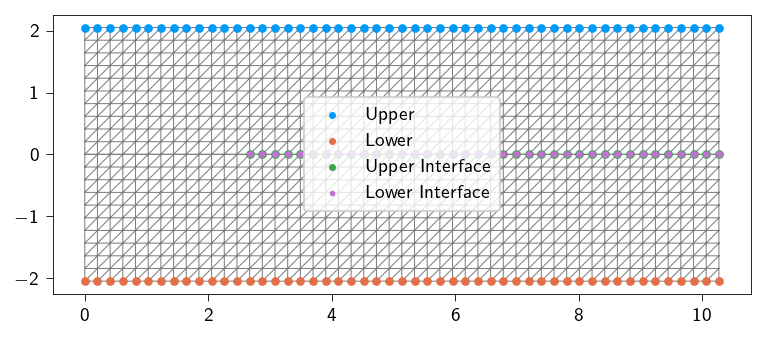

In [105]:
# --- Apply Dirichlet BCs ---
y_max = jnp.max(coords[:, 1])
y_min = jnp.min(coords[:, 1])

y_min_upper_body = jnp.min(upper_coords[:, 1])
y_max_lower_body = jnp.max(lower_coords[:, 1])

# left_upper_nodes = jnp.where(jnp.isclose(coords[:, 0], 0.0) & (coords[:, 1] >= 0))[0]
# left_lower_nodes = jnp.where(jnp.isclose(coords[:, 0], 0.0) & (coords[:, 1] < 0))[0]
upper_nodes = jnp.where(jnp.isclose(coords[:, 1], y_max))[0]
lower_nodes = jnp.where(jnp.isclose(coords[:, 1], y_min))[0]
upper_interface_nodes = jnp.where(
    jnp.isclose(coords[:, 1], y_min_upper_body) & (coords[:, 0] > crack_length)
)[0]
lower_interface_nodes = jnp.where(
    jnp.isclose(coords[:, 1], y_max_lower_body) & (coords[:, 0] > crack_length)
)[0]


fixed_dofs = jnp.concatenate(
    [
        2 * upper_nodes,
        2 * upper_nodes + 1,
        2 * lower_nodes,
        2 * lower_nodes + 1,
        #2 * upper_interface_nodes + 1,
        #2 * lower_interface_nodes + 1,
    ]
)


applied_disp = prestrain * Ly

prescribed_values = jnp.zeros(n_dofs).at[2 * upper_nodes].set(0.0)
prescribed_values = prescribed_values.at[2 * upper_nodes + 1].set(applied_disp/2.)
prescribed_values = prescribed_values.at[2 * lower_nodes].set(0.0)
prescribed_values = prescribed_values.at[2 * lower_nodes + 1].set(-applied_disp/2.)
#prescribed_values = prescribed_values.at[2 * upper_interface_nodes + 1].set(0.0)
#prescribed_values = prescribed_values.at[2 * lower_interface_nodes + 1].set(0.0)

free_dofs = jnp.setdiff1d(jnp.arange(n_dofs), fixed_dofs)


# --- Plot the mesh ---
# We plot the mesh the nodes that are fixed on the left and right edges.

plt.style.use(STYLE_PATH)
plt.figure(figsize=(6, 3))
ax = plt.axes()
ax.triplot(coords[:, 0], coords[:, 1], elements, color="grey", lw=0.5)

ax.scatter(coords[upper_nodes, 0], coords[upper_nodes, 1], s=10, label="Upper")
ax.scatter(coords[lower_nodes, 0], coords[lower_nodes, 1], s=10, label="Lower")
ax.scatter(
    coords[upper_interface_nodes, 0],
    coords[upper_interface_nodes, 1],
    s=10,
    label="Upper Interface",
)
ax.scatter(
    coords[lower_interface_nodes, 0],
    coords[lower_interface_nodes, 1],
    s=5,
    label="Lower Interface",
)
ax.legend()
ax.set_aspect("equal")
ax.legend(loc="center")
plt.show()

In [106]:
@auto_vmap(lower_element=1, upper_element=1)
def create_cohesive_elements(lower_element, upper_element):
    return jnp.array([lower_element[0], lower_element[1], upper_element[1], upper_element[0]])


cohesive_elements = create_cohesive_elements(lower_elements_1d, upper_elements_1d)

In [107]:
from femsolver import sparse

In [108]:
sparsity_pattern = sparse.create_sparsity_pattern(
    elements, n_dofs_per_node, (n_dofs, n_dofs), cohesive_elements
)

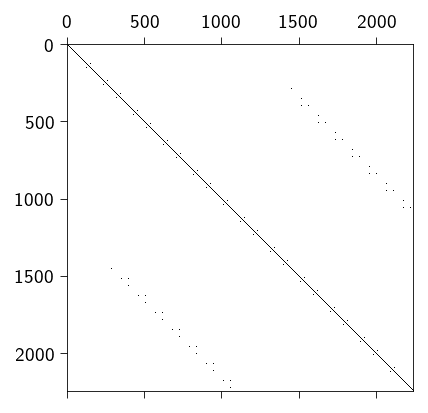

In [109]:
plt.style.use(STYLE_PATH)
plt.figure(figsize=(3,3))
plt.spy(sparsity_pattern.todense())
plt.show()

In [110]:
import sparsejac

In [111]:
gradient = jax.jacrev(total_energy)
hessian_sparse = sparsejac.jacfwd(gradient, sparsity=sparsity_pattern)

In [112]:
zero_indices, one_indices = sparse.get_bc_indices(
    sparsity_pattern.indices, fixed_dofs
)

In [122]:
# ------------- Newton-Raphson Solver -------------------
def newton_solver(
    fixed_dofs,
    u_target_flat,
    n_steps,
    tol=1e-8,
    max_iter=20,
):

    du_total = u_target_flat / n_steps  # displacement increment
    u = jnp.zeros(n_nodes * n_dofs_per_node)
    fext = jnp.zeros(n_nodes * n_dofs_per_node)

    A = PETSc.Mat()
    A.createAIJ(size=(n_dofs, n_dofs))

    b = A.createVecLeft()
    du = A.createVecRight()

    errors = []

    for step in range(n_steps):
        print(f"Step {step+1}/{n_steps}")
        u = u.at[fixed_dofs].set((step + 1) * du_total[fixed_dofs])

        fint = gradient(u)
        K_sparse = hessian_sparse(u)

        iiter = 0
        norm_res = 1.0

        while norm_res > tol and iiter < max_iter:
            residual = fext - fint
            residual = residual.at[fixed_dofs].set(0)

            K_sparse_bc = K_sparse.data.at[zero_indices].set(0)
            K_sparse_bc = K_sparse_bc.at[one_indices].set(1)

            A.zeroEntries()
            for index, value in zip(sparsity_pattern.indices, K_sparse_bc):
                row, col = index
                A.setValue(row, col, value)
            A.assemble()

            ksp = PETSc.KSP().create()
            ksp.setOperators(A)

            b.zeroEntries()
            b.setArray(residual)

            ksp.setConvergenceHistory()
            ksp.getPC().setType("none")
            du.zeroEntries()
            ksp.solve(b, du)

            ksp.destroy()

            u = u.at[:].add(du.getArray())

            fint = gradient(u)
            K_sparse = hessian_sparse(u)

            residual = fext - fint
            residual = residual.at[fixed_dofs].set(0)

            norm_res = jnp.linalg.norm(residual)
            print(f"  Residual: {norm_res:.2e}")

            iiter += 1

        errors.append(norm_res)

    return u.reshape(-1, n_dofs_per_node), errors

In [123]:
u_solution, errors = newton_solver(
    fixed_dofs=fixed_dofs,
    u_target_flat=prescribed_values,
    n_steps=50,
    tol=1e-8,
    max_iter=30,
)

Step 1/50
  Residual: 3.20e+04
  Residual: 4.69e+03
  Residual: 1.69e+03
  Residual: 6.85e+02
  Residual: 3.31e+03
  Residual: 4.11e+03
  Residual: 1.39e+03
  Residual: 2.83e+03
  Residual: 1.00e+04
  Residual: 9.20e+03
  Residual: 8.16e+03
  Residual: 4.91e+03
  Residual: 3.48e+03
  Residual: 5.75e+03
  Residual: 2.36e+03
  Residual: 6.58e+03
  Residual: 7.11e+03
  Residual: 6.88e+03
  Residual: 5.47e+03
  Residual: 3.21e+03
  Residual: 1.31e+04
  Residual: 7.91e+03
  Residual: 3.25e+04
  Residual: 8.54e+03
  Residual: 8.17e+03
  Residual: 3.42e+03
  Residual: 7.77e+03
  Residual: 9.41e+03
  Residual: 9.91e+03
  Residual: 5.24e+03
Step 2/50
  Residual: 6.33e+03
  Residual: 9.04e+03
  Residual: 6.75e+03
  Residual: 6.45e+03
  Residual: 4.04e+03
  Residual: 5.49e+03
  Residual: 6.31e+03
  Residual: 8.26e+04
  Residual: 5.92e+03
  Residual: 5.78e+03
  Residual: 6.79e+03
  Residual: 6.21e+03
  Residual: 4.38e+03
  Residual: 5.81e+03
  Residual: 9.10e+03
  Residual: 3.69e+03
  Residual: 7.

KeyboardInterrupt: 

In [124]:
plt.style.use(STYLE_PATH)
plt.figure(figsize=(5, 4))
plt.semilogy(errors, marker="o")
plt.xlabel("Increment step")
plt.ylabel("Residual")
plt.ylim(1e-14, 1e-8)
plt.grid(True)
plt.show()

NameError: name 'errors' is not defined

<Figure size 750x600 with 0 Axes>

In [113]:
u_lower_bounds = jnp.full(n_dofs, -jnp.inf)
u_upper_bounds = jnp.full(n_dofs, jnp.inf)

u_lower_bounds = u_lower_bounds.at[:].set(prescribed_values)
u_lower_bounds = u_lower_bounds.at[free_dofs].set(-jnp.inf)
u_upper_bounds = u_upper_bounds.at[:].set(prescribed_values)
u_upper_bounds = u_upper_bounds.at[free_dofs].set(jnp.inf)

In [114]:

class JAXMatMult:
    def __init__(self, gradient: Callable):
        self.x_cur = None
        self.gradient = gradient

    def set_x(self, x: Array):
        """Set the current iterate for the Jacobian-vector product."""
        self.x_cur = x

    def mult(self, A, X, F):
        """Set dF = J(x) * dx"""
        dx = X.getArray(readonly=True)
        tangent = jax.jvp(self.gradient, (self.x_cur,), (dx,))[1]
        F[:] = tangent


class ElasticityProblem:
    def __init__(self, func):
        self.gradient = func
        self.ctx = JAXMatMult(func)

    def set_sol(self, sol):
        self.sol_cur = sol

    def function(self, snes, X, F):
        print(X.getArray(readonly=True))
        x = jnp.array(X.getArray(readonly=True))
        f = self.gradient(x)
        F[:] = f

    def jacobian(self, snes, X, J, P):
        self.ctx.set_x(X.getArray(readonly=True))
        return True

In [115]:
gradient = jax.jacrev(total_energy)
problem = ElasticityProblem(gradient)

In [116]:

snes = PETSc.SNES().create(comm=PETSc.COMM_SELF)
f = PETSc.Vec().createSeq(n_dofs)
J = PETSc.Mat().createPython(
    [n_dofs, n_dofs], comm=PETSc.COMM_SELF, context=problem.ctx
)
J.setUp()


alpha_lb = f.duplicate()
alpha_ub = f.duplicate()
alpha_lb.setArray(u_lower_bounds.reshape(-1))
alpha_ub.setArray(u_upper_bounds.reshape(-1))

snes.setFunction(problem.function, f)
snes.setJacobian(problem.jacobian, J, J)
snes.setType("vinewtonrsls")
snes.setVariableBounds(alpha_lb, alpha_ub)
snes.setTolerances(atol=1e-8, rtol=1e-8, max_it=20)
snes.setConvergenceHistory()
snes.setConvergedReason(reason=PETSc.SNES.ConvergedReason.CONVERGED_FNORM_ABS)

convergence_history = []
snes.setMonitor(lambda _snes, its, norm: convergence_history.append(norm))

# using matrix-free method to solve the linear system
ksp =snes.getKSP()
ksp.setType("cg")
ksp.setTolerances(rtol=1e-10, atol=1e-10)
ksp.setConvergedReason(reason=PETSc.KSP.ConvergedReason.CONVERGED_ATOL)
b, alpha = None, f.duplicate()


alpha.setArray(u.reshape(-1))  # zero inital guess
snes.solve(b, alpha)
print(snes.getConvergedReason())

u_solution = alpha.getArray().reshape((n_nodes, n_dofs_per_node))
_ = snes.destroy()

[0. 0. 0. ... 0. 0. 0.]
[ 2.84445408e-11  1.02664050e-02  2.56488370e-11 ... -1.02664050e-02
  2.12385158e-11 -1.02664050e-02]
3


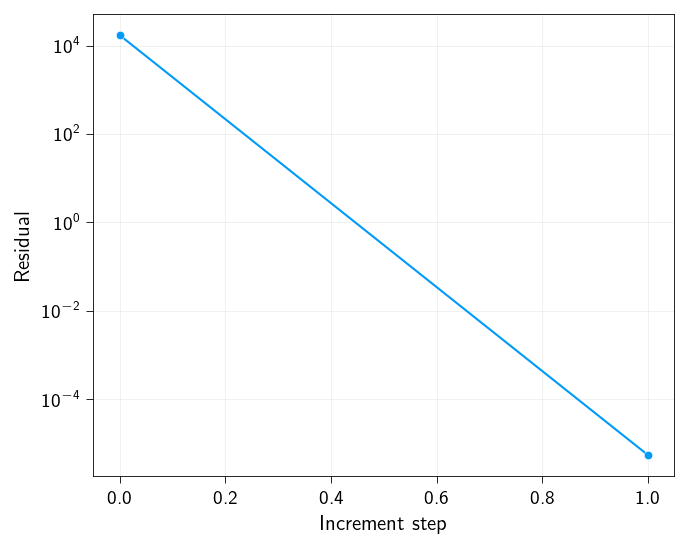

In [117]:
plt.style.use(STYLE_PATH)
plt.figure(figsize=(5, 4))
plt.semilogy(convergence_history, marker="o")
plt.xlabel("Increment step")
plt.ylabel("Residual")
plt.grid(True)
plt.show()

Now we prepare some functions to compute the stress and to plot the deformed shape with the von-mises stress.

In [118]:
@auto_vmap(stress=2)
def von_mises_stress(stress):
    s_xx, s_yy = stress[0, 0], stress[1, 1]
    s_xy = stress[0, 1]
    return jnp.sqrt(s_xx**2 - s_xx * s_yy + s_yy**2 + 3 * s_xy**2)


In [119]:
# squeeze to remove the quad point dimension (only 1 quad point)
grad_u = op.grad(u_solution).squeeze()
strains = compute_strain(grad_u)
stresses = compute_stress(strains, mat.mu, mat.lmbda)
stress_vm = von_mises_stress(stresses)

In [120]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_displacement_and_stress(u, mesh, stress, scale=1.0):
    displaced = mesh.coords + scale * u
    tri_elements = mesh.elements

    plt.style.use(STYLE_PATH)
    fig = plt.figure(figsize=(5, 4))
    ax = plt.axes()
    cb = ax.tripcolor(
        displaced[:, 0],
        displaced[:, 1],
        tri_elements,
        facecolors=stress,
        shading="flat",
        cmap=cmc.managua_r,
        edgecolors="black",
    )
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect("equal")
    ax.set_title("Von Mises Stress on Deformed Mesh")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(cb, cax=cax)
    plt.show()

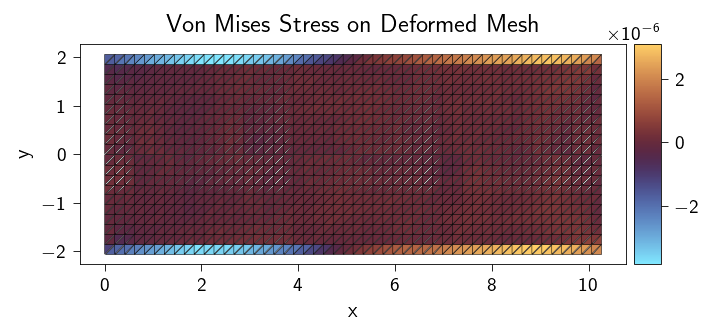

In [121]:
plot_displacement_and_stress(u_solution, mesh, stresses[:, 0, 1].flatten())

## Dynamic fracture

Now, we will solve the dynamic fracture problem. We will use the explicit time integration scheme to solve the problem.


The governing equation for the dynamic fracture problem is given as

$$
\rho \frac{\partial^2 u}{\partial t^2} - \nabla \cdot \sigma = f_{ext}
$$

where $\rho$ is the density, $u$ is the displacement, $\sigma$ is the stress, $f_{ext}$ is the external force, and $f$ is the internal force.



### Assembling mass matrix

The total mass of the system is given as
$$
m = \int \rho  dV
$$


In [115]:
rho = 1.0

class MassOperator(Operator):
    element: Element

    @auto_vmap(xi=1, wi=1, nodal_values=None, nodes=None)
    def integrand(self, xi, wi, nodal_values, nodes):
        u_quad, u_grad, detJ = self.element.get_local_values(xi, nodal_values, nodes)
        rho = 1.0
        return wi * rho * u_quad * detJ

In [116]:
mass_op = MassOperator(element=tri3)

In [117]:
def total_mass(
    nodal_values_flat: jnp.ndarray,
    coords: jnp.ndarray,
    elements: jnp.ndarray,
    mass_op: Operator,
):
    nodal_values = nodal_values_flat.reshape(-1, n_dofs_per_node)
    return jnp.sum(mass_op.integrate(nodal_values[elements], coords[elements]))

In [118]:
ones = jnp.ones(n_dofs) 
mass_vector = jax.jacrev(total_mass)(ones, coords, elements, mass_op)

### Explicit time integration scheme

We present the explicit time integration scheme based on the Newmark-$\beta$ method.








**Predictor**

$$
u^{0}_{n+1} = u_{n} + \Delta t \dot{u}_{n} + \frac{1}{2} \Delta t^2  \ddot{u}_{n}
$$

$$
\dot{u}^{0}_{n+1} = \dot{u}_{n} + \Delta t \ddot{u}_{n}
$$

$$
\ddot{u}^{0}_{n+1} = \ddot{u}_{n}
$$


**Solve**

$$
\delta \ddot{u} = \frac{1}{\boldsymbol{M}} (f_{\text{ext}, n+1} - f_{\text{int}}(u_{n+1}^{i}) - \boldsymbol{M}\ddot{u}^{i}_{n+1})
$$




**Corrector**

$$
\ddot{u}^{i+1}_{n+1} = \ddot{u}^{i}_{n+1} + \delta\ddot{u}
$$

$$
\dot{u}^{i+1}_{n+1} = \dot{u}^{i}_{n+1} + \frac{1}{2} \Delta t  \delta \ddot{u}^{i+1}_{n+1}
$$




In [119]:
def predictor(u, v, a, dt):
    u_pred = u + dt * v + 0.5 * dt**2 * a
    v_pred = v + dt * a
    a_pred = a
    return u_pred, v_pred, a_pred

def corrector(u_pred, v_pred, a_pred, da, dt):
    a_new = a_pred + da
    v_new = v_pred + 0.5 * dt * da
    return u_pred, v_new, a_new


The explicit time integration is conditionally stable. The critical time step is given by:

$$
\Delta t \leq \frac{h}{c}
$$

where $h$ is the minimum element size and $c$ is the wave speed.

The wave speed is given by:

$$ 
c = \sqrt{\frac{\mu + \lambda}{\rho}}
$$

where $\mu$ and $\lambda$ are the Lame parameters and $\rho$ is the density.

The minimum element size is the radius of the inscribed circle of the element. Below we define a function to compute the radius of the inscribed circle of the element.


In [120]:
@auto_vmap(coords=2)
def get_inscribed_circle_radius(coords):
    c1, c2, c3 = coords
    a = jnp.linalg.norm(c2 - c1)
    b = jnp.linalg.norm(c3 - c2)
    c = jnp.linalg.norm(c1 - c3)
    s = (a + b + c) / 2
    area = jnp.sqrt(s * (s - a) * (s - b) * (s - c))
    return area / s / 2


In [121]:
h_min = jnp.min(get_inscribed_circle_radius(coords[elements]))
dt = 0.05 * h_min / (jnp.sqrt((2 * elasticity_op.mu + elasticity_op.lmbda) / rho))

print(f"critical time step: {dt}")

critical time step: 4.039869723525841e-06


Now, we can use the explicit time integration to solve the dynamic fracture problem. The initial conditions are given by the static solution.

In [122]:

boundary_dofs = jnp.concatenate(
    [
        2 * upper_nodes,
        2 * upper_nodes + 1,
        2 * lower_nodes,
        2 * lower_nodes + 1,
    ]
)

In [123]:
n_steps = 2

u_dynamic = u_static.flatten()
v_dynamic = jnp.zeros_like(u_dynamic)
a_dynamic = jnp.zeros_like(u_dynamic)

f_ext = jnp.zeros_like(u_dynamic)

for step in range(n_steps):

    u_dynamic = u_dynamic.at[boundary_dofs].set(prescribed_values.at[boundary_dofs].get())
    
    u_pred, v_pred, a_pred = predictor(u_dynamic, v_dynamic, a_dynamic, dt)

    residual = f_ext - gradient(u_pred)

    residual = residual.at[boundary_dofs].set(0)
    da = residual / mass_vector  -  mass_vector * a_dynamic

    
    u_dynamic, v_dynamic, a_dynamic = corrector(u_pred, v_pred, a_pred, da, dt)
    

In [124]:

def plot_nodal_values(coords, u, elements, nodal_values, scale=1.0):
    displaced = coords + scale * u
    tri_elements = elements

    plt.style.use(STYLE_PATH)
    fig =plt.figure(figsize=(5, 4))
    ax = plt.axes()
    cb =ax.tripcolor(
        displaced[:, 0],
        displaced[:, 1],
        tri_elements,
        nodal_values,
        shading="flat",
        cmap=cmc.managua_r,
        edgecolors="black",
    )
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect("equal")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(cb, cax=cax)
    plt.show()

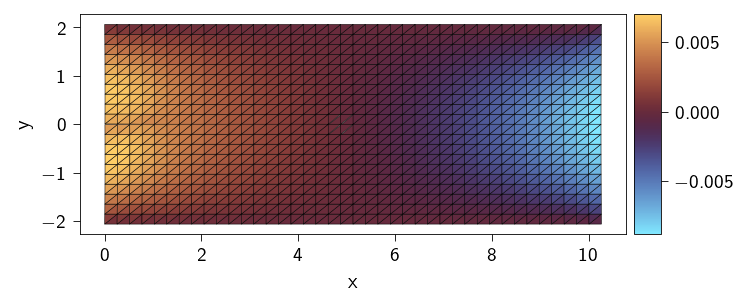

In [125]:
plot_nodal_values(
    coords,
    u_dynamic.reshape(-1, n_dofs_per_node),
    elements,
    nodal_values=u_dynamic.reshape(-1, n_dofs_per_node)[:, 0].flatten(),
)

In [126]:
@eqx.filter_vmap(in_axes=(0, 0))
def compute_quadrature_openings(nodal_values, nodes):
    qi, w = line2.get_quadrature()
  
    def quadrature_values(xi):
        jump_quad, jump_grad, detJ = line2.get_local_values(xi, nodal_values, nodes)
        
        #opening_quad = compute_opening(jump_quad, nodes)
        return jump_quad[1]

    return jax.vmap(quadrature_values)(qi)


@eqx.filter_vmap(in_axes=(0))
def compute_quadrature_points(nodes):
    qi, w = line2.get_quadrature()

    def quadrature_values(xi):
        u_quad, u_grad, detJ = line2.get_local_values(xi, nodes, nodes)
        return u_quad

    return jax.vmap(quadrature_values)(qi)

In [127]:
u = u_dynamic.reshape(-1, n_dofs_per_node)
u_upper = u[upper_elements_1d]
u_lower = u[lower_elements_1d]
# we compute the jump in the displacement field across the cohesive interface
jump_values = u_upper - u_lower
# since the two interfaces are identical, we can use the coordinates of the upper interface
# to intergate and compute the fracture energy
x_upper_cell = coords[upper_elements_1d]

quadrature_points_interface = compute_quadrature_points(x_upper_cell)[:, :, 0].flatten()

In [128]:
quadrature_openings_interface = compute_quadrature_openings(jump_values, x_upper_cell).flatten()

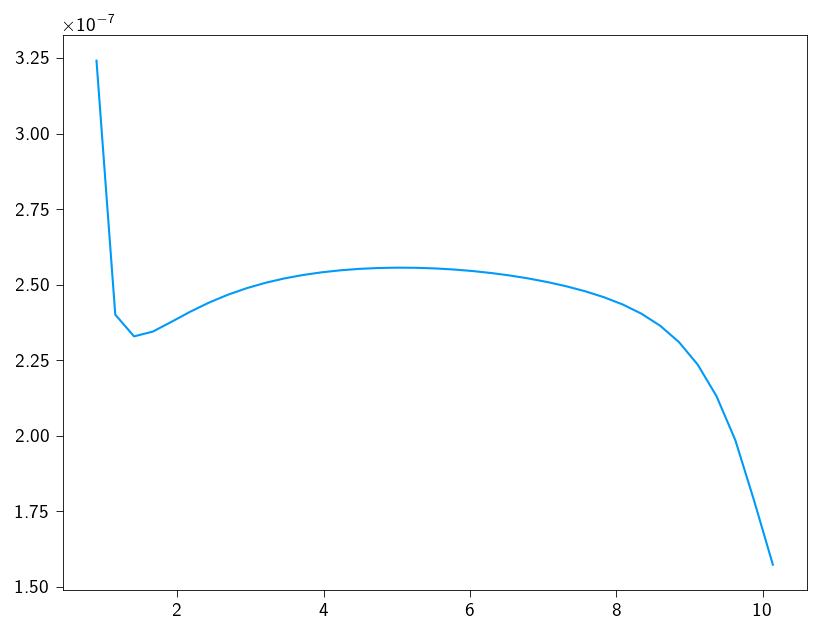

In [129]:
plt.plot(quadrature_points_interface, quadrature_openings_interface)
plt.show()